In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import HawkesKernelPowerLaw, SimuHawkes, HawkesKernelTimeFunc
from tick.base import TimeFunction
optimalParams = []
nNeurons = 100

Alphas = np.zeros([nNeurons,4])
Alpha0 = -np.zeros([1,4])
Betas = np.zeros([nNeurons,4])
Beta0 = np.zeros([nNeurons,4])

epsilon = 1e-8

Dict={x: {} for x in range(4)}
Dict_integrate = {x: {} for x in range(4)}  #nested dictionary for all networks
Dict_gradient = {x: {} for x in range(4)}

MapT1T2={}
adjacentKernel={0:[0,1],1:[3,2]}
para = np.zeros([4,2])
#power kernel = alpha*(delta+t)^(-beta)

#simulation part



def createMapAtoBIndex(a,b):
    mapAtoBIndex={}
    for x in a:
        if(max(b[b<x],default=-1)==-1):
            mapAtoBIndex[x] = None
        else:
            mapAtoBIndex[x] = (np.where(b==max(b[b<x])))
    return mapAtoBIndex
    


def exponentialIntegratedKernel(tend,kernel):
    alpha = para[kernel,0]
    beta = para[kernel,1]
    
    res = (alpha/beta)*(1-np.exp(-beta*tend))
    
    return res

def exponentialKernel(tp,kernel):
    alpha = para[kernel,0]
    beta = para[kernel,1]
    res = alpha*np.exp(-beta*tp)
   
    return res


    

def loglikelihood():
    
    T = max(t[0][-1],t[1][-1])
    ll=0
    
    
    
    for p in range(0,2,1):
        tend = (T-t[p][:])
        a = np.sum(exponentialIntegratedKernel(tend.reshape(1,-1),p))
        
        a = a + np.sum(exponentialIntegratedKernel(tend.reshape(1,-1),p+2))
        
        
        
        ll = ll+ mu[p]*T+a
       
        
        ll = ll-np.log(mu[p])
       
        tp = t[p][:]  
        otherP = (p==0)*1
        
        tOtherP = t[otherP][:]
        for i in range(1,len(tp),1):
            li = max(i-30,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(exponentialKernel(temp1.reshape(1,-1),adjacentKernel[p][0]))
            jT = MapT1T2[p][tp[i]]
           
            if(jT != None):
                j = np.asscalar(jT[0])
                lj = max(j-30,0)
                temp2 = tp[i]-tOtherP[lj:j+1]
                decayFactor = decayFactor + np.sum(exponentialKernel(temp2.reshape(1,-1),adjacentKernel[p][1]))
            logLam = -np.log(mu[p]+decayFactor)
            
            ll = ll+logLam
        
    return ll

def gradientIntegratedKernel(tend,p):
    alpha = para[p,0]
    beta = para[p,1]
    fac1 = np.exp(-beta*tend)
    val = np.zeros([2])
    val[0]=(1/beta)*(1-fac1)
   
    fac2 = (alpha/beta)*(-(1/beta)+fac1*((1/beta)+tend))
    val[1] = fac2
    return val

def gradientExpKernel(temp,p):
    alpha = para[p,0]
    beta = para[p,1]
    fac1 = np.exp(-beta*temp)
    val = np.zeros([2])
    val[0]=np.sum(fac1)
    val[1]= -alpha*np.sum(temp*fac1)
    return val
    

def gradientll(iArray):
    
    T = max(t[0][-1],t[1][-1])
    
    grad = np.zeros([4,2])
    for i in range(0,max(iArray.shape),1):
        factor1=0
        factor2=0
        p = iArray[0,i]
        index = iArray[1,i]
        tend = (T-t[p][index])
        grad[p,:]=grad[p,:]+gradientIntegratedKernel(tend,p)
        
        grad[p+2,:]=grad[p+2,:]+gradientIntegratedKernel(tend,p+2)
        
        li = max(index-30,0)
        temp1 = t[p][index]-t[p][li:index]
        decayFactor = np.sum(exponentialKernel(temp1.reshape(1,-1),adjacentKernel[p][0]))
        factor1=  gradientExpKernel(temp1,adjacentKernel[p][0])
        jT = MapT1T2[p][t[p][index]]
        otherP = (p==0)*1
        if(jT != None):
            j = np.asscalar(jT[0])
            lj = max(j-30,0)
            temp2 = t[p][index]-t[otherP][lj:j+1]
            decayFactor = decayFactor + np.sum(exponentialKernel(temp2.reshape(1,-1),adjacentKernel[p][1]))
            factor2 = gradientExpKernel(temp2,adjacentKernel[p][1])
        
        lam = mu[p]+decayFactor
        grad[adjacentKernel[p][0],:] = grad[adjacentKernel[p][0],:] - (1/lam)*factor1
        
        grad[adjacentKernel[p][1],:] = grad[adjacentKernel[p][1],:] - (1/lam)*factor2
        
    print(grad/max(iArray.shape))
                             
    return grad/max(iArray.shape)

def sgdHawkes():
    global para
    lr =0.01
    beta_1 = 0.9
    beta_2 =0.999
    epsilon = 1e-8
    count = 0
    bestll = 1e8
    bestpara = np.zeros([4,2])
    m_t = np.zeros([4,2])
    v_t = np.zeros([4,2])
    lenT1 = len(t[0][:])
    lenT2 = len(t[1][:])
    totalLength = lenT1+lenT2
    tCompressed = np.zeros((2,totalLength)).astype(int)
    tCompressed[:,lenT1:totalLength]=1
    tCompressed[1,0:lenT1]=range(0,lenT1,1)
    tCompressed[1,lenT1:totalLength]=range(0,lenT2,1)
    
    for epochs in range(1,30,1):
        
        rsample = np.random.choice(totalLength,totalLength,replace = False)
        for i in range(0,len(rsample),100):
            count=count+1 
            grad = gradientll(tCompressed[:,rsample[i:i+100]])
            m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            para = para-(lr*m_cap)/(np.sqrt(v_cap)+epsilon)
            
            error=loglikelihood()
            error2=alternate_loglikelihood()
            bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            para = np.maximum(para,0)
            bestll = min(bestll,error)
            
            print(i,error,error2, bestll,'\n',para)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara  
    

## plots
def plotKernels(p):
    showIntegratedKernel = True
    dx=0.01
    
    tk = np.arange(0,5,dx)
    interestX = Dict[p]['inflection']
    
    y1 = alpha*np.exp(-beta*tk).reshape(-1)
    y2 = nnKernel(tk.reshape(1,-1),p).reshape(-1)
    y3 = (alpha/beta)*(1 - np.exp(-beta*tk)).reshape(-1)
    y4= np.cumsum(y2*dx).reshape(-1)
    y5 = nnIntegratedKernel(tk.reshape(1,-1),p).reshape(-1)
    
    plt.plot(tk.reshape(-1), y1,'tab:blue')
    plt.plot(tk.reshape(-1),y2,'tab:orange')
    #
    if(showIntegratedKernel):
        plt.plot(tk.reshape(-1), y3,'tab:green')
        plt.plot(tk.reshape(-1),y4,'tab:red')
        plt.plot(tk.reshape(-1),y5,'tab:brown')

    plt.grid()
    plt.pause(0.005)

def plotKernelsAll():
    
    showIntegratedKernel = False
    dx=0.01
    
    tk = np.arange(0,5,dx)
    y1 = np.zeros([len(tk),4])
    y2 = np.zeros([len(tk),4])
    y3 = np.zeros([len(tk),4])
    y4 = np.zeros([len(tk),4])
    y5 = np.zeros([len(tk),4])
    
    for p in range(4):
        interestX = Dict[p]['inflection']
    
        #y1[:,p] = alpha*np.exp(-beta*tk)
        y2[:,p] = nnKernel(tk.reshape(1,-1),p)

        #y3[:,p] = (alpha/beta)*(1 - np.exp(-beta*tk))
   
    

        
        y4[:,p] = np.cumsum(y2[:,p]*dx)
        #y5[:,p] = nnIntegratedKernel(tk.reshape(1,-1),p)



    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    p=0
    fig.suptitle('Sharing x per column, y per row')
    #ax1.plot(tk.reshape(-1), y1[:,p],'tab:blue')
    ax1.plot(tk.reshape(-1),y2[:,p],'tab:orange')
    #
    if(showIntegratedKernel):
        ax1.plot(tk.reshape(-1), y3[:,p],'tab:green')
        ax1.plot(tk.reshape(-1),y4[:,p],'tab:red')
        ax1.plot(tk.reshape(-1),y5[:,p],'tab:brown')
    
    p=1
    
    #ax2.plot(tk.reshape(-1), y1[:,p],'tab:blue')
    ax2.plot(tk.reshape(-1),y2[:,p],'tab:orange')
    #
    if(showIntegratedKernel):
        ax2.plot(tk.reshape(-1), y3[:,p],'tab:green')
        ax2.plot(tk.reshape(-1),y4[:,p],'tab:red')
        ax2.plot(tk.reshape(-1),y5[:,p],'tab:brown')
    
    p= 2
    
    #ax3.plot(tk.reshape(-1), y1[:,p],'tab:blue')
    ax3.plot(tk.reshape(-1),y2[:,p],'tab:orange')
    #
    if(showIntegratedKernel):
        ax3.plot(tk.reshape(-1), y3[:,p],'tab:green')
        ax3.plot(tk.reshape(-1),y4[:,p],'tab:red')
        ax3.plot(tk.reshape(-1),y5[:,p],'tab:brown')
    
    p=3
    #ax4.plot(tk.reshape(-1), y1[:,p],'tab:blue')
    ax4.plot(tk.reshape(-1),y2[:,p],'tab:orange')
    #
    if(showIntegratedKernel):
        ax4.plot(tk.reshape(-1), y3[:,p],'tab:green')
        ax4.plot(tk.reshape(-1),y4[:,p],'tab:red')
        ax4.plot(tk.reshape(-1),y5[:,p],'tab:brown')
   
    return
## Code for Neural Hawkes starts here##

def inflectionPoints():
    
    for p in range(4):
        alphas = Alphas[:,p]
    
        betas = Betas[:,p]
        beta0 = Beta0[:,p]
    
        div = betas+epsilon*(np.abs(betas)<epsilon) # potentially error prone
        x = -beta0/div
        interestX1 = x*(x>0)
        alwaysInclude = (x<=0)*(betas>0) #dont change
        alwaysExclude = (x<=0)*(betas<0)
        tempX = x*(~alwaysInclude)*(~alwaysExclude)
        interestX1 = tempX[interestX1>0]
        interestX = np.sort(interestX1)
        interestX = np.append(0,interestX)
        
        Dict[p]['inflection'] = interestX
   
        con = alphas*betas
        Dict[p]['constant'] = con
    return

def nnIntegratedKernel(x,p):
    x = x.reshape(-1)
    alphas = Alphas[:,p].reshape(-1,1)
    alpha0 = Alpha0[:,p].reshape(-1,1)
    betas = Betas[:,p].reshape(-1,1)
    beta0 = Beta0[:,p].reshape(-1,1)
    const1 = Dict[p]['constant']
    interestX = Dict[p]['inflection']
    precalculate_integrate(p)
    
    y = np.zeros([1,max(x.shape)])
    
    for i in range(0,max(x.shape)):
        xi = x[i]
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1 = betas*(xi-epsilon) + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            
            term1 = nnKernel(xi,p)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP,p)*((const!=0)+iP*(const==0))
            
            const = (const)*(const!=0)+(const==0)*1.0
            
            prev_term = Dict_integrate[p][iP]
            
            y[0,i] = prev_term + ((term1-term2)/(const))
        
       
               

    return y

def nnKernel(x,p):
    alphas = Alphas[:,p].reshape(-1,1)
    alpha0 = Alpha0[:,p]
    betas = Betas[:,p].reshape(-1,1)
    beta0 = Beta0[:,p].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y    


def initializeParams(nNeurons):
    
    
    for kernel in range(4):
        Alphas[:,kernel] = -(np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
        Alpha0[:,kernel] = -np.random.uniform(0,1,1)*0.5
        Betas[:,kernel] = (np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
        Beta0[:,kernel] = np.random.uniform(0,1,nNeurons).reshape(-1)*0.05
       
    return mu



def precalculate_integrate(kernel):
    alphas = Alphas[:,kernel].reshape(-1,1)
    alpha0 = Alpha0[:,kernel].reshape(-1,1)
    betas = Betas[:,kernel].reshape(-1,1)
    beta0 = Beta0[:,kernel].reshape(-1,1)
    iP = Dict[kernel]['inflection']
    const1 = Dict[kernel]['constant']
    Dict_integrate[kernel].clear()
    Dict_integrate[kernel][0]=0
    y = 0
    for index in range(1,len(iP)):
        n1 = betas*(iP[index]-epsilon) + beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)
            
            
        term1 = nnKernel(iP[index],kernel)*((const!=0)+iP[index]*(const==0))
        term2 = nnKernel(iP[index-1],kernel)*((const!=0)+iP[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
        Dict_integrate[kernel][iP[index]]=y
    return
    
def precalculate_gradient(kernel):
    alphas = Alphas[:,kernel].reshape(-1,1)
    alpha0 = Alpha0[:,kernel].reshape(-1,1)
    betas = Betas[:,kernel].reshape(-1,1)
    beta0 = Beta0[:,kernel].reshape(-1,1)
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    iP = Dict[kernel]['inflection']
    
    const1 = Dict[kernel]['constant']
    Dict_gradient[kernel].clear()
    Dict_gradient[kernel][0]=list([gradA0,gradA,gradB1,gradB0])
    for index in range(1,len(iP)):
            
            n0pr = betas*(iP[index-1]+epsilon)+beta0
            n1pr = betas*(iP[index]-epsilon) + beta0
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP[index-1])+beta0
            n1 = betas*(iP[index]) + beta0
            
            fac1 = nnKernel(iP[index],kernel)
            fac2 = nnKernel(iP[index-1],kernel)
            gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
            gradA = gradA -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
            gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0))))*(~indicator)
            Dict_gradient[kernel][iP[index]]= list([gradA0,gradA,gradB1,gradB0])
            
    return
    
def gradientNNIntegratedKernel(tend,kernel):
    
    alphas = Alphas[:,kernel].reshape(-1,1)
    alpha0 = Alpha0[:,kernel].reshape(-1,1)
    betas = Betas[:,kernel].reshape(-1,1)
    beta0 = Beta0[:,kernel].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    
    if(tend>0):
        const1 = Dict[kernel]['constant']
        interestX = Dict[kernel]['inflection']
            
        iP = max(interestX[interestX<tend])
        n1pr = betas*(tend-epsilon) + beta0
        n0pr = betas*(tend+epsilon)+beta0
           
        dn1 = (n1pr>0)
        dn0 = (n0pr>0)
        const =np.dot(const1.T,dn1)
        indicator = const==0
        const = const*(const!=0)+1*(const==0)
        n0 = betas*(iP)+beta0
        n1 = betas*(tend) + beta0
        fac1 = nnKernel(tend,kernel)
        fac2 = nnKernel(iP,kernel)
        gradients = Dict_gradient[kernel][iP]
            
            
        gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(tend-iP)
            
        gradA = gradA + gradients[1] -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
        gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            
        gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
        gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*tend*dn1-fac2*iP*dn0))*(~indicator)
    
        gradB0 =gradB0+ gradients[3] + ((1/const)*((alphas)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0))))*(~indicator)
    return list([gradA0,gradA,gradB1,gradB0])

def gradientNNKernel(temp,kernel):
    alphas = Alphas[:,kernel].reshape(-1,1)
    alpha0 = Alpha0[:,kernel]
    betas = Betas[:,kernel].reshape(-1,1)
    beta0 = Beta0[:,kernel].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    fac1 = nnKernel(temp.reshape(1,-1),kernel)
    
    
   
    n1 = np.dot(betas,temp.reshape(1,-1)) + beta0
    gradA = gradA + np.sum(fac1*np.maximum(n1,0),axis=1).reshape(-1,1)
        
    gradA0 = gradA0 + np.sum(fac1)
        
    gradB1 = gradB1 + np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
    gradB0 = gradB0 + np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)
    return list([gradA0,gradA,gradB1,gradB0])
    
    

def gradientNetwork(iArray):
    
    T = max(t[0][-1],t[1][-1])
    gradA0 = np.zeros([1,4])
    gradA = np.zeros([nNeurons,4])
    gradB1 = np.zeros([nNeurons,4])
    gradB0 = np.zeros([nNeurons,4])
    nSamples = max(iArray.shape)
    
    for kernel in range(0,4,1):
        precalculate_gradient(kernel)
    
    for i in range(0,nSamples,1):
        p = iArray[0,i]
        index = iArray[1,i]
        tend = (T-t[p][index])
        out = gradientNNIntegratedKernel(tend,p)
       
        gradA0[:,p]=gradA0[:,p]+out[0]
        gradA[:,p]=gradA[:,p]+out[1].reshape(-1)
        gradB1[:,p]=gradB1[:,p]+out[2].reshape(-1)
        gradB0[:,p]=gradB0[:,p]+out[3].reshape(-1)
        
        out = gradientNNIntegratedKernel(tend,p+2)
        gradA0[:,p+2]=gradA0[:,p+2]+out[0]
        gradA[:,p+2]=gradA[:,p+2]+out[1].reshape(-1)
        gradB1[:,p+2]=gradB1[:,p+2]+out[2].reshape(-1)
        gradB0[:,p+2]=gradB0[:,p+2]+out[3].reshape(-1)
        
        li = max(index-10,0)
        kernel0 = adjacentKernel[p][0]
        kernel1 = adjacentKernel[p][1]
        temp1 = t[p][index]-t[p][li:index]
        decayFactor = np.sum(nnKernel(temp1.reshape(1,-1),kernel0))
        out =  gradientNNKernel(temp1,kernel0)
        jT = MapT1T2[p][t[p][index]]
        otherP = (p==0)*1
        if(jT != None):
            j = np.asscalar(jT[0])
            lj = max(j-10,0)
            temp2 = t[p][index]-t[otherP][lj:j+1]
            decayFactor = decayFactor + np.sum(nnKernel(temp2.reshape(1,-1),kernel1))
            out2 = gradientNNKernel(temp2,kernel1)
        
        lam = mu[p]+decayFactor
        invLam = (1/lam)
        
        
        gradA0[:,kernel0]=gradA0[:,kernel0] -invLam*out[0]
        gradA[:,kernel0]=gradA[:,kernel0] -invLam*out[1].reshape(-1)
        gradB1[:,kernel0]=gradB1[:,kernel0]-invLam*out[2].reshape(-1)
        gradB0[:,kernel0]=gradB0[:,kernel0] -invLam*out[3].reshape(-1)
        
        if(jT != None):
            gradA0[:,kernel1]=gradA0[:,kernel1] -invLam*out2[0]
            gradA[:,kernel1]=gradA[:,kernel1] -invLam*out2[1].reshape(-1)
            gradB1[:,kernel1]=gradB1[:,kernel1]-invLam*out2[2].reshape(-1)
            gradB0[:,kernel1]=gradB0[:,kernel1] -invLam*out2[3].reshape(-1)
        
    gradA0 = gradA0/(nSamples)
    gradA = gradA/nSamples
    gradB1 = gradB1/nSamples
    gradB0 = gradB0/nSamples
        
    return list([gradA0,gradA,gradB1,gradB0])
     


def nnLoglikelihood():
    
    T = max(t[0][-1],t[1][-1])
    ll=0
    
    for p in range(0,2,1):
        tend = (T-t[p][:])
        a = np.sum(nnIntegratedKernel(tend.reshape(1,-1),p))
       
        
        a = a + np.sum(nnIntegratedKernel(tend.reshape(1,-1),p+2))
        
        
        
        
        ll = ll+ mu[p]*T+a
       
        
        ll = ll-np.log(mu[p])
        llinit = ll
        tp = t[p][:]  
        otherP = (p==0)*1
        
        tOtherP = t[otherP][:]
        for i in range(1,len(tp),1):
            li = max(i-10,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(nnKernel(temp1.reshape(1,-1),adjacentKernel[p][0]))
            jT = MapT1T2[p][tp[i]]
           
            if(jT != None):
                j = np.asscalar(jT[0])
                lj = max(j-10,0)
                temp2 = tp[i]-tOtherP[lj:j+1]
                decayFactor = decayFactor + np.sum(nnKernel(temp2.reshape(1,-1),adjacentKernel[p][1]))
            logLam = -np.log(mu[p]+decayFactor)
            
            ll = ll+logLam
       
    return ll

def sgdNeuralHawkesBiVariate(nEpochs,lr):
    
    global Alpha0
    global Alphas
    global Betas
    global Beta0
    
    lr2 =lr*0.05
    lr_mu = lr*0.1
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    neg_ll = []
    
    optimalParams = list([Alpha0,Alphas,Betas,Beta0])
    
    m_t_A = np.zeros([nNeurons,4])
    m_t_A0 =np.zeros([1,4])
    m_t_B= np.zeros([nNeurons,4])
    m_t_B0= np.zeros([nNeurons,4])
    m_t = 0
    v_t_A = np.zeros([nNeurons,4])
    v_t_A0 =np.zeros([1,4])
    v_t_B= np.zeros([nNeurons,4])
    v_t_B0= np.zeros([nNeurons,4])
    v_t = 0
    count = 0
    lenT1 = len(t[0][:])
    lenT2 = len(t[1][:])
    totalLength = lenT1+lenT2
    tCompressed = np.zeros((2,totalLength)).astype(int)
    tCompressed[:,lenT1:totalLength]=1
    tCompressed[1,0:lenT1]=range(0,lenT1,1)
    tCompressed[1,lenT1:totalLength]=range(0,lenT2,1)
    inflectionPoints()
    error=nnLoglikelihood()
    neg_ll.append(error)
    for epochs in range(1,nEpochs+1,1):
        inflectionPoints()
        
        rsample = np.random.choice(totalLength,totalLength,replace = False)
        #plotKernels(0)
        for i in range(0,len(rsample),50):
            count=count+1 
            grad = gradientNetwork(tCompressed[:,rsample[i:i+50]])
            
           # m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
           # v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
           # m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
           # v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
           # mu = mu-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
           # mu = np.maximum(mu,0)
           
           
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*grad[0]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(grad[0]*grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alpha0 = Alpha0-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon) 
                         
                   
            m_t_A = beta_1*m_t_A + (1-beta_1)*grad[1]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(grad[1]*grad[1])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alphas = Alphas-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            

            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*grad[2]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(grad[2]*grad[2])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas = Betas-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*grad[3]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(grad[3]*grad[3])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Beta0 = Beta0 -(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
        error=nnLoglikelihood()
        neg_ll.append(error)
            #bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            
        if(bestll > error):
            optimalParams = list([Alpha0,Alphas,Betas,Beta0])
                
               
            
        bestll = min(bestll,error)
        print(i,epochs,bestll,error,mu)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
        #plotKernelsAll()
    return optimalParams,neg_ll,nEpochs
            
            




/opt/tljh/user/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import numpy as np

from tick.hawkes import (SimuHawkes, HawkesKernelTimeFunc, HawkesKernel0)
from tick.base import TimeFunction

run_time = 60000

t_values1 = np.array([0, 1, 1.5, 2., 3.5], dtype=float)
y_values1 = np.array([0, 0.2, 0, 0.1, 0.], dtype=float)
tf1 = TimeFunction([t_values1, y_values1],
                   inter_mode=TimeFunction.InterConstRight, dt=0.1)
kernel1 = HawkesKernelTimeFunc(tf1)

t_values2 = np.linspace(0, 4, 20)
y_values2 = np.maximum(0., np.sin(t_values2) / 4)
tf2 = TimeFunction([t_values2, y_values2])
kernel2 = HawkesKernelTimeFunc(tf2)

kernel3 = HawkesKernelTimeFunc(
    t_values=np.array([0., .7, 2.5, 3., 4.]),
    y_values=np.array([.3, .03, .03, .2, 0.]))

baseline = np.array([0.05, 0.05])

hawkes = SimuHawkes(baseline=baseline, end_time=run_time, verbose=False,
                    seed=2334)

hawkes.set_kernel(0, 0, kernel1)
hawkes.set_kernel(0, 1, kernel2)
hawkes.set_kernel(1, 0, HawkesKernel0())
hawkes.set_kernel(1, 1, kernel3)

hawkes.simulate()

t = hawkes.timestamps
#t[0]=np.array(simu_univariate(alpha,beta,mu[0],1000))







In [3]:
t1 = np.array(t[0][:]).reshape(-1)
t2 = np.array(t[1][:]).reshape(-1)
MapT1T2[0] = createMapAtoBIndex(t1,t2)
MapT1T2[1] = createMapAtoBIndex(t2,t1)



para = np.zeros([4,2])
para[:,1]=3
para[:,0]=0.2
para[2,0]=0
#print(loglikelihood())

mu = baseline

initializeParams(nNeurons)

SGD = sgdNeuralHawkesBiVariate(100,0.01)

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:606: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:545: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


11350 1 35297.38782477334 35297.38782477334 [0.05 0.05]
11350 2 35122.44212222362 35122.44212222362 [0.05 0.05]
11350 3 34831.6950220227 34831.6950220227 [0.05 0.05]
11350 4 34569.02606679117 34569.02606679117 [0.05 0.05]
11350 5 34499.44764401292 34499.44764401292 [0.05 0.05]
11350 6 34369.6053373139 34369.6053373139 [0.05 0.05]
11350 7 34369.6053373139 34430.94666669654 [0.05 0.05]
11350 8 34289.24205843068 34289.24205843068 [0.05 0.05]
11350 9 34289.24205843068 34374.54514784089 [0.05 0.05]
11350 10 34111.78886712292 34111.78886712292 [0.05 0.05]
11350 11 34111.78886712292 34276.5205345361 [0.05 0.05]
11350 12 34111.78886712292 34142.4412411711 [0.05 0.05]
11350 13 34111.78886712292 34172.173261722855 [0.05 0.05]
11350 14 34103.664997833665 34103.664997833665 [0.05 0.05]
11350 15 34103.664997833665 34157.50482352222 [0.05 0.05]
11350 16 34103.664997833665 34105.47436460418 [0.05 0.05]
11350 17 34086.474600079666 34086.474600079666 [0.05 0.05]
11350 18 34086.474600079666 34097.232468

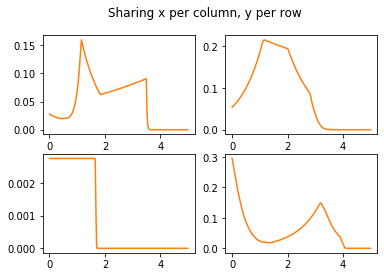

In [4]:
plotKernelsAll()

In [5]:
def nnOptimalKernel(x,p):
    optimalkernel = SGD[0]
    Alpha0 = optimalkernel[0]
    Alphas = optimalkernel[1]
    Betas = optimalkernel[2]
    Beta0 = optimalkernel[3]
    alphas = Alphas[:,p].reshape(-1,1)
    alpha0 = Alpha0[:,p]
    betas = Betas[:,p].reshape(-1,1)
    beta0 = Beta0[:,p].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y

In [89]:
#to plot tick.base.time_function 
def _extended_discrete_xaxis(x_axis, n_points=100, eps=0.10):

    min_value = np.min(x_axis)
    max_value = np.max(x_axis)
    distance = max_value - min_value
    return np.linspace(min_value - eps * distance, max_value + eps * distance,
                       num=n_points)


def plot_timefunction(time_function, labels=None, n_points=300, show=True,
                      ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        show = False

    if time_function.is_constant:
        if labels is None:
            labels = ['value = %.3g' % time_function.border_value]

        t_values = np.arange(10).astype('float')
        ax.plot(t_values, time_function.value(t_values), label= 'Theoretical value')

    else:
        if labels is None:
            interpolation_to_legend = {
                TimeFunction.InterLinear: 'Linear',
                TimeFunction.InterConstLeft: 'Constant on left',
                TimeFunction.InterConstRight: 'Constant on right'
            }

            border_to_legend = {
                TimeFunction.Border0:
                    'border zero',
                TimeFunction.BorderConstant:
                    'border constant at %.3g' % time_function.border_value,
                TimeFunction.BorderContinue:
                    'border continue',
                TimeFunction.Cyclic:
                    'cyclic'
            }

            labels = [
                'original points',
                '%s and %s' %
                (interpolation_to_legend[time_function.inter_mode],
                 border_to_legend[time_function.border_type])
            ]

        original_t = time_function.original_t
        if time_function.border_type == TimeFunction.Cyclic:
            cycle_length = original_t[-1]
            original_t = np.hstack((original_t, original_t + cycle_length,
                                    original_t + 2 * cycle_length))

        t_values = _extended_discrete_xaxis(original_t, n_points=n_points)

        #ax.plot(time_function.original_t, time_function.original_y, ls='',
                #marker='o', label=labels[0])
        ax.plot(t_values, time_function.value(t_values), 'k', label='Theoretical value')

    ax.legend()
    if show is True:
        plt.show()

    return ax.figure

/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)


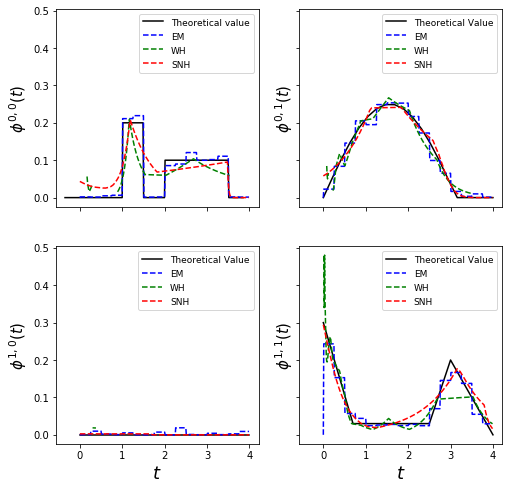

In [90]:
#Kernel plot
from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern
#from tick.plot import plot_timefunction
timestamp = t
support = 1000

em = HawkesEM(kernel_support = 5, kernel_size=20, n_threads=8, verbose=False, tol=1e-3)
wh = HawkesConditionalLaw(claw_method="log", delta_lag=0.1, min_lag=0.002,
                         max_lag=100, quad_method="log", n_quad=50,
                         min_support=0.002, max_support=support, n_threads=-1)
#learner = HawkesSumExpKern(decays = [beta], penalty='elasticnet',
                           #elastic_net_ratio=0.8)

#fit the model
em.fit(t)
wh.incremental_fit(t)
wh.compute()
#learner.fit(t)

#get node
c_nodes = em.n_nodes

#tk
dx=0.01
tk = np.arange(0,4,dx)
y2 = np.zeros([len(tk),4])
for p in range(4):
    y2[:,p] = nnOptimalKernel(tk.reshape(1,-1),p)



#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
    
p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        if i == 0:
            if j == 0:
                plot_timefunction(tf1,ax=ax)
            else:
                t_value = np.linspace(0, 4, 20)
                y_value = np.maximum(0., np.sin(t_value) / 4)
                ax.plot(t_value, y_value,'k', label="Theoretical Value")
        else:
            if j == 0:
                t_value=np.array([0,1,2,3,4])
                y_value=np.array([0,0,0,0,0])
                ax.plot(t_value, y_value,'k', label="Theoretical Value" )
            else:
                t_value=np.array([0., .7, 2.5, 3., 4.])
                y_value=np.array([.3, .03, .03, .2, 0.])
                ax.plot(t_value, y_value,'k', label="Theoretical Value" )
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'b--', label="EM")
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'g--', label="WH")
        y_values = y2[:,p]
        ax.plot(tk, y_values,'r--', label="SNH")
       
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$\phi^{%g,%g}(t)$" % (i, j), fontsize=15)
        
        legend = ax.legend(loc='upper right')
        for label in legend.get_texts():
            label.set_fontsize(9)

plt.savefig("2D_random_kernels.png")



In [91]:
#to plot y_value of time function
def _extended_discrete_xaxis(x_axis, n_points=100, eps=0.10):

    min_value = np.min(x_axis)
    max_value = np.max(x_axis)
    distance = max_value - min_value
    return np.linspace(min_value - eps * distance, max_value + eps * distance,
                       num=n_points)


def plot_timefunction(time_function, labels=None, n_points=300, show=True,
                      ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        show = False

    if time_function.is_constant:
        if labels is None:
            labels = ['value = %.3g' % time_function.border_value]

        t_values = np.arange(10).astype('float')
        ax.plot(t_values, time_function.value(t_values), label= 'Theoretical value')

    else:
        if labels is None:
            interpolation_to_legend = {
                TimeFunction.InterLinear: 'Linear',
                TimeFunction.InterConstLeft: 'Constant on left',
                TimeFunction.InterConstRight: 'Constant on right'
            }

            border_to_legend = {
                TimeFunction.Border0:
                    'border zero',
                TimeFunction.BorderConstant:
                    'border constant at %.3g' % time_function.border_value,
                TimeFunction.BorderContinue:
                    'border continue',
                TimeFunction.Cyclic:
                    'cyclic'
            }

            labels = [
                'original points',
                '%s and %s' %
                (interpolation_to_legend[time_function.inter_mode],
                 border_to_legend[time_function.border_type])
            ]

        original_t = time_function.original_t
        if time_function.border_type == TimeFunction.Cyclic:
            cycle_length = original_t[-1]
            original_t = np.hstack((original_t, original_t + cycle_length,
                                    original_t + 2 * cycle_length))

        t_values = _extended_discrete_xaxis(original_t, n_points=n_points)

        #ax.plot(time_function.original_t, time_function.original_y, ls='',
                #marker='o', label=labels[0])
        #ax.plot(t_values, time_function.value(t_values), 'k', label='Theoretical value')

    ax.legend()
    if show is True:
        plt.show()

    return t_values, time_function.value(t_values)

No handles with labels found to put in legend.
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: invalid value encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/opt/tljh/user/lib/python3.6/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)


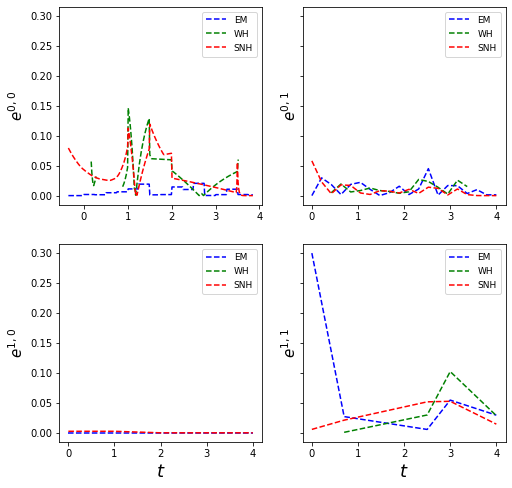

In [92]:
#L1 error

#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=False,
                                         sharey=True,figsize=(8, 8))

p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        if i == 0:
            if j == 0:
                #t_value = np.array([0, 1, 1.5, 2., 3.5])
                temp = plot_timefunction(tf1,ax=ax)
                t_value = temp[0]
                y_value = temp[1]
            else:
                t_value = np.linspace(0, 4, 20)
                y_value = np.maximum(0., np.sin(t_values2) / 4)
        else:
            if j == 0:
                t_value=np.array([0,1,2,3,4])
                y_value=np.array([0,0,0,0,0])
            else:
                t_value=np.array([0., .7, 2.5, 3., 4.])
                y_value=np.array([.3, .03, .03, .2, 0.])
        em_values = em.get_kernel_values(i, j, t_value)
        error1 = np.abs(y_value-em_values)
        ax.plot(t_value, error1,'b--', label="EM")
        wh_values = wh.get_kernel_values(i, j, t_value)
        error2 = np.abs(y_value-wh_values)
        ax.plot(t_value, error2,'g--', label='WH')
        y2 = np.zeros([len(t_value),4])
        y2[:,p] = nnOptimalKernel(t_value.reshape(1,-1),p)
        error4 = np.abs(y_value-y2[:,p])
        ax.plot(t_value, error4,'r--', label="SNH")
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$e^{%g,%g}$" % (i, j), fontsize=15)
        
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)
#fig.tight_layout()


plt.savefig("2D_random_error.png")
